# Line Detection for the P&ID digitization

* Code to detect horizontal and vertical lines
* Return the coordinates of the lines
* Check for shifted lines and return unified line

In [5]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random, os
import numpy as np
import pandas as pd
import math

In [22]:
# function for image processing and 
# line detection
# checks shifted lines and suggests
# unified line

from dataclasses import dataclass
@dataclass(frozen=True)
class Point:
    x: int
    y: int
    def transpose(self):
        return Point(self.y, self.x)
    
@dataclass(frozen=True)
class Line:
    a: Point
    b: Point
    def length(self):
        return abs(self.a.x - self.b.x) + abs(self.a.y - self.b.y)
    def transpose(self):
        return Line(self.a.transpose(), self.b.transpose())
   
def prepare_image(path):
    im = path
    # import image
    img = cv2.imread(im, cv2.IMREAD_UNCHANGED)
    # transform to gray scale
    img_gray = 255 - img[:, :, 3]
    # tranform to one and zeros
    image_new = np.empty((img_gray.shape[0], img_gray.shape[1]), 
                         dtype=int)
    for row in range(img_gray.shape[0]):
        for col in range(img_gray.shape[1]):
            if img_gray[row][col] == 255:
                image_new[row][col] = 0
            else:
                image_new[row][col] = int(math.ceil(img_gray[row][col]/255))
    plt.imshow(image_new,cmap='gray', vmin=0, vmax=1)
    return image_new
    
def horizontal_lines(image):

    # find indices of horizontal parallel lines
    def find_indices(image):
        X_all=[]
        Y_all=[]
        for row in range(image.shape[0]):
            X=[]
            Y=[]
            for col in range(image.shape[1]):
                if image[row][col] != 0:
                    X.append(col)
                    Y.append(row)
            if X != []:
                X_all.append(X)
                Y_all.append(Y)    
        return X_all, Y_all

    # find lines that are horizontal
    def horizontal_line(X):
        numbers = sorted(set(X))
        gaps = [[start, end] for start, end in zip(numbers, numbers[1:]) if start + 1 < end]
        edges = iter(numbers[:1] + sum(gaps, []) + numbers[-1:])
        return list(zip(edges, edges))

    # print coordinates of starting, ending point
    def print_coordinates(image):
        results = []
        # calculate indices
        X_all, Y_all = find_indices(image)
        for i in range(len(X_all)):
            for pair in horizontal_line(X_all[i]):
                l = Line(Point(pair[0],Y_all[i][0]), Point(pair[1], Y_all[i][0]))
                if l.length() > 1:
                    results.append(l)
        return results    
    
    return print_coordinates(image)

def vertical_lines(image):
    image = np.transpose(image)
    lines = horizontal_lines(image)
    return [l.transpose() for l in lines]

def find_lines(path):
    image = prepare_image(path)
    hor_lines = horizontal_lines(image)
#     print("hor lines", hor_lines)
    ver_lines = vertical_lines(image)
#     print("\nver lines", ver_lines)
#     return hor_lines + ver_lines
    return hor_lines, ver_lines, hor_lines + ver_lines

# check for lines that are a segment
# but during scanning appear in a slightly
# different X, or Y horizontally
def find_shifted_lines_hor(lines):
    x = []
    y = []
    for line1 in lines:
        for line2 in lines:
            if abs(line2.a.x - line1.b.x) < 3 and abs(line2.a.y - line1.b.y) < 3:
                x.extend((line1.a.x, line1.b.x, line2.a.x, line2.b.x))
                y.extend((line1.a.y, line1.b.y, line2.a.y, line2.b.y))
                print("\nLines that belong together are:")                
                print("Line 1, start x,y = %d,%d - end x,y = %d,%d" %(line1.a.x, line1.a.y, line1.b.x, line1.b.y))
                print("Line 2, start x,y = %d,%d - end x,y = %d,%d\n" %(line2.a.x, line2.a.y, line2.b.x, line2.b.y))
                
    print("x min and max", min(x), max(x))
    print("y min and max", min(y), max(y))
    
    print("New continuous horizontal line start at x,y = %d, %d and ends at x,y = %d, %d" %(min(x), min(y),  max(x), min(y)))
    
# check for lines that are a segment
# but during scanning appear in a slightly
# different X, or Y vertically
def find_shifted_lines_ver(lines):
    x = []
    y = []
    for line1 in lines:
        for line2 in lines:
            if abs(line2.a.x - line1.b.x) < 3 and abs(line2.a.y - line1.b.y) < 3:
                x.extend((line1.a.x, line1.b.x, line2.a.x, line2.b.x))
                y.extend((line1.a.y, line1.b.y, line2.a.y, line2.b.y))
                print("\nLines that belong together are:")                
                print("Line 1, start x,y = %d,%d - end x,y = %d,%d" %(line1.a.x, line1.a.y, line1.b.x, line1.b.y))
                print("Line 2, start x,y = %d,%d - end x,y = %d,%d\n" %(line2.a.x, line2.a.y, line2.b.x, line2.b.y))
                
    print("x min and max", min(x), max(x))
    print("y min and max", min(y), max(y))
    
    print("New continuous vertical line start at x,y = %d, %d and ends at x,y = %d, %d" %(min(x), min(y),  min(x), max(y)))    

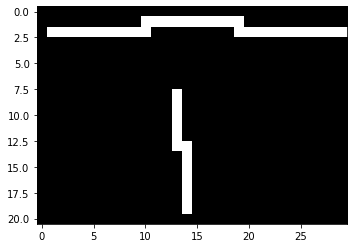

In [23]:
hor, ver, all_lines = find_lines('lines_offset_ver_hor_5dpi30x21.png')

In [24]:
# coordinates of lines detected
print("Coordinates of lines detected: \n", all_lines)
# check for shifted lines in the horizontal axis
find_shifted_lines_hor(hor)
# check for shifted lines in the vertical axis
find_shifted_lines_ver(ver)

Coordinates of lines detected: 
 [Line(a=Point(x=10, y=1), b=Point(x=19, y=1)), Line(a=Point(x=1, y=2), b=Point(x=10, y=2)), Line(a=Point(x=19, y=2), b=Point(x=29, y=2)), Line(a=Point(x=13, y=8), b=Point(x=13, y=13)), Line(a=Point(x=14, y=13), b=Point(x=14, y=19))]

Lines that belong together are:
Line 1, start x,y = 10,1 - end x,y = 19,1
Line 2, start x,y = 19,2 - end x,y = 29,2


Lines that belong together are:
Line 1, start x,y = 1,2 - end x,y = 10,2
Line 2, start x,y = 10,1 - end x,y = 19,1

x min and max 1 29
y min and max 1 2
New continuous horizontal line start at x,y = 1, 1 and ends at x,y = 29, 1

Lines that belong together are:
Line 1, start x,y = 13,8 - end x,y = 13,13
Line 2, start x,y = 14,13 - end x,y = 14,19

x min and max 13 14
y min and max 8 19
New continuous vertical line start at x,y = 13, 8 and ends at x,y = 13, 19


In [25]:
# check for shifted lines in the horizontal axis
find_shifted_lines_hor(hor)


Lines that belong together are:
Line 1, start x,y = 10,1 - end x,y = 19,1
Line 2, start x,y = 19,2 - end x,y = 29,2


Lines that belong together are:
Line 1, start x,y = 1,2 - end x,y = 10,2
Line 2, start x,y = 10,1 - end x,y = 19,1

x min and max 1 29
y min and max 1 2
New continuous horizontal line start at x,y = 1, 1 and ends at x,y = 29, 1


In [26]:
# check for shifted lines in the vertical axis
find_shifted_lines_ver(ver)


Lines that belong together are:
Line 1, start x,y = 13,8 - end x,y = 13,13
Line 2, start x,y = 14,13 - end x,y = 14,19

x min and max 13 14
y min and max 8 19
New continuous vertical line start at x,y = 13, 8 and ends at x,y = 13, 19
